In [2]:
"""Jarvis-dgl data loaders and DGLGraph utilities."""

import random
from pathlib import Path
from typing import Optional

# from typing import Dict, List, Optional, Set, Tuple

import os
import torch
import dgl
import numpy as np
import pandas as pd
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph, StructureDataset

# from jarvis.core.graphs import Graph, StructureDataset
from jarvis.db.figshare import data as jdata
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
from jarvis.db.jsonutils import dumpjson

# from sklearn.pipeline import Pipeline
import pickle as pk

# from sklearn.decomposition import PCA  # ,KernelPCA
from sklearn.preprocessing import StandardScaler

# use pandas progress_apply
tqdm.pandas()

In [3]:
import json
from pathlib import Path

def load_dataset_from_files(directory_path: str, target: str = None):
    """Load data from a directory of JSON files."""
    directory_path = Path(directory_path)
    data = []
    
    for file_path in directory_path.glob('*.json'):
        with open(file_path, 'r', encoding='utf-8') as file:
            file_data = json.load(file)
            # Check if the target exists in the file data
            if target is None or (target in file_data and file_data[target] != "na"):
                data.append(file_data)
    
    return data


In [4]:
directory_path = r'C:\Users\DongIn\Desktop\New_json'  # Update with your actual directory path
import joblib  # or import pickle
cache_file = r'N:\개인\학부연구생\2024 춘계 화학공학회\코드\atom graph\data_cache.pkl'  # Define a cache file path

# Check if the cache file exists
if Path(cache_file).exists():
    # Load the preprocessed dataset from the cache
    dataset = joblib.load(cache_file)
else:
    # Preprocess the dataset
    dataset = load_dataset_from_files(directory_path)  # This is your data loading and preprocessing logic
    # Save the preprocessed dataset to the cache
    joblib.dump(dataset, cache_file)

In [5]:
df=pd.DataFrame(dataset)

In [13]:
df

,id,cif,lcd,pld,void_fraction,surface_area_m2g,surface_area_m2cm3,CH4_pressure,CH4_ads,max_CH4_ads,min_CH4_ads
0,15339,data_functionalizedCrystal\n_audit_creation_me...,11.75,10.75,0.795539,3676.3,2262.5,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0186721, 0.176655, 0.332851, 0.925975, 1.7128]",1.712800,0.018672
1,15344,data_functionalizedCrystal\n_audit_creation_me...,4.75,3.25,0.388986,580.7,714.8,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0337722, 0.279838, 0.527366, 1.0238, 1.57016]",1.570160,0.033772
2,15348,data_functionalizedCrystal\n_audit_creation_me...,4.75,3.75,0.307505,377.6,562.5,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.025019, 0.214103, 0.371126, 0.702208, 0.860...",0.860103,0.025019
3,15438,data_functionalizedCrystal\n_audit_creation_me...,9.25,8.25,0.731919,3399.2,2418.3,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0296359, 0.260543, 0.427824, 1.17743, 2.0276]",2.027600,0.029636
4,16338,data_functionalizedCrystal\n_audit_creation_me...,3.75,2.75,0.323803,85.2,133.4,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0154192, 0.214703, 0.251459, 0.69745, 1.10894]",1.108940,0.015419
...,...,...,...,...,...,...,...,...,...,...,...
137647,25186,data_functionalizedCrystal\n_audit_creation_me...,10.25,9.25,0.669211,1261.3,1792.3,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0374412, 0.342791, 0.565304, 1.3177, 2.10299]",2.102990,0.037441
137648,25187,data_functionalizedCrystal\n_audit_creation_me...,5.25,3.25,0.537672,1211.4,1695.6,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0196261, 0.198196, 0.32853, 0.80785, 1.50306]",1.503060,0.019626
137649,25188,data_functionalizedCrystal\n_audit_creation_me...,10.25,8.75,0.776322,2405.4,2102.3,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0163842, 0.159966, 0.291332, 0.780811, 1.36...",1.365890,0.016384
137650,25190,data_functionalizedCrystal\n_audit_creation_me...,5.25,3.25,0.445350,603.6,1055.0,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0685724, 0.601389, 0.936168, 1.59223, 1.96293]",1.962930,0.068572


In [7]:
# 'max_CH4_ads' 열의 값이 0이 아닌 행을 필터링하여 데이터프레임을 업데이트
df = df[df['surface_area_m2g'] != 0]

In [14]:
import os
import pandas as pd

# 'df'는 pandas 데이터 프레임이고, 이미 로드되어 있다고 가정합니다.

# 0을 포함하는 'CH4_ads' 리스트를 가진 행을 필터링
rows_with_zero = df[df['CH4_ads'].apply(lambda x: 0 in x)]

# 제거할 VASP 파일의 이름을 생성하고 파일 삭제
for index, row in rows_with_zero.iterrows():
    jid = row['id']
    poscar_name = f"POSCAR-hMOF-{jid}.vasp"  # poscar_name 생성
    
    # 해당 파일이 현재 디렉토리에 존재하는지 확인 후 삭제
    if os.path.exists(poscar_name):
        os.remove(poscar_name)
        print(f"Deleted file: {poscar_name}")

Deleted file: POSCAR-hMOF-53020.vasp
Deleted file: POSCAR-hMOF-53467.vasp
Deleted file: POSCAR-hMOF-53833.vasp
Deleted file: POSCAR-hMOF-54177.vasp
Deleted file: POSCAR-hMOF-54221.vasp
Deleted file: POSCAR-hMOF-165604.vasp
Deleted file: POSCAR-hMOF-165606.vasp
Deleted file: POSCAR-hMOF-165614.vasp
Deleted file: POSCAR-hMOF-165621.vasp
Deleted file: POSCAR-hMOF-165625.vasp
Deleted file: POSCAR-hMOF-165640.vasp
Deleted file: POSCAR-hMOF-54265.vasp
Deleted file: POSCAR-hMOF-165660.vasp
Deleted file: POSCAR-hMOF-165667.vasp
Deleted file: POSCAR-hMOF-165669.vasp
Deleted file: POSCAR-hMOF-54300.vasp
Deleted file: POSCAR-hMOF-54355.vasp
Deleted file: POSCAR-hMOF-165745.vasp
Deleted file: POSCAR-hMOF-165786.vasp
Deleted file: POSCAR-hMOF-54292.vasp
Deleted file: POSCAR-hMOF-54415.vasp
Deleted file: POSCAR-hMOF-165804.vasp
Deleted file: POSCAR-hMOF-165850.vasp
Deleted file: POSCAR-hMOF-165858.vasp
Deleted file: POSCAR-hMOF-54447.vasp
Deleted file: POSCAR-hMOF-165865.vasp
Deleted file: POSCAR-hM

In [15]:
len(rows_with_zero)

369

In [9]:
df_filtered = df[~df['CH4_ads'].apply(lambda x: 0 in x)]

In [16]:
df_filtered

,id,cif,lcd,pld,void_fraction,surface_area_m2g,surface_area_m2cm3,CH4_pressure,CH4_ads,max_CH4_ads,min_CH4_ads
0,15339,data_functionalizedCrystal\n_audit_creation_me...,11.75,10.75,0.795539,3676.3,2262.5,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0186721, 0.176655, 0.332851, 0.925975, 1.7128]",1.712800,0.018672
1,15344,data_functionalizedCrystal\n_audit_creation_me...,4.75,3.25,0.388986,580.7,714.8,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0337722, 0.279838, 0.527366, 1.0238, 1.57016]",1.570160,0.033772
2,15348,data_functionalizedCrystal\n_audit_creation_me...,4.75,3.75,0.307505,377.6,562.5,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.025019, 0.214103, 0.371126, 0.702208, 0.860...",0.860103,0.025019
3,15438,data_functionalizedCrystal\n_audit_creation_me...,9.25,8.25,0.731919,3399.2,2418.3,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0296359, 0.260543, 0.427824, 1.17743, 2.0276]",2.027600,0.029636
4,16338,data_functionalizedCrystal\n_audit_creation_me...,3.75,2.75,0.323803,85.2,133.4,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0154192, 0.214703, 0.251459, 0.69745, 1.10894]",1.108940,0.015419
...,...,...,...,...,...,...,...,...,...,...,...
137647,25186,data_functionalizedCrystal\n_audit_creation_me...,10.25,9.25,0.669211,1261.3,1792.3,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0374412, 0.342791, 0.565304, 1.3177, 2.10299]",2.102990,0.037441
137648,25187,data_functionalizedCrystal\n_audit_creation_me...,5.25,3.25,0.537672,1211.4,1695.6,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0196261, 0.198196, 0.32853, 0.80785, 1.50306]",1.503060,0.019626
137649,25188,data_functionalizedCrystal\n_audit_creation_me...,10.25,8.75,0.776322,2405.4,2102.3,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0163842, 0.159966, 0.291332, 0.780811, 1.36...",1.365890,0.016384
137650,25190,data_functionalizedCrystal\n_audit_creation_me...,5.25,3.25,0.445350,603.6,1055.0,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0685724, 0.601389, 0.936168, 1.59223, 1.96293]",1.962930,0.068572


In [17]:
import tempfile
import os
import dgl
import torch
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from typing import Optional
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph  # Ensure this is correctly imported based on your setup

# id_prop.csv 생성 코드 개선
prop = "CH4_ads"
max_samples = len(df_filtered)

# 파일 작성을 with 문을 사용하여 개선
with open("id_prop.csv", "w") as f:
    count = 0
    for index, row in df_filtered.iterrows():
        if row[prop] != "na":
            jid = row["id"]
            poscar_name = "POSCAR-hMOF-" + str(jid) + ".vasp"
            cif_str = row["cif"]
            target = ""
            for j in row[prop]:
                target += "," + str(j)
            f.write("%s,%s\n" % (poscar_name, target))
            count += 1
            if count == max_samples:
                break


In [7]:
# Assuming 'df' is your DataFrame and 'max_CH4_ads' is the continuous target variable
# Binning the 'max_CH4_ads' into 10 bins and storing the bin labels in a new column
df_filtered['bin'] = pd.qcut(df_filtered['max_CH4_ads'], q=20, labels=False, duplicates='drop')

# Ensuring the sample size is proportional to the original bin sizes, with a total of 10000 samples
sample_sizes = df_filtered['bin'].value_counts(normalize=True) * 2000

C:\Users\DongIn\AppData\Local\Temp\ipykernel_16196\3042694742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['bin'] = pd.qcut(df_filtered['max_CH4_ads'], q=20, labels=False, duplicates='drop')


In [8]:
# Initialize an empty DataFrame for the sampled data
sampled_df = pd.DataFrame()

for bin_label, size in sample_sizes.items():
    bin_sample = df_filtered[df_filtered['bin'] == bin_label].sample(n=int(size), random_state=42)
    sampled_df = pd.concat([sampled_df, bin_sample])

# Dropping the 'bin' column as it's no longer needed
sampled_df = sampled_df.drop(columns=['bin'])

In [9]:
sampled_df

,id,cif,lcd,pld,void_fraction,surface_area_m2g,surface_area_m2cm3,CH4_pressure,CH4_ads,max_CH4_ads,min_CH4_ads
110760,128705,data_functionalizedCrystal\n_audit_creation_me...,8.75,7.75,0.696247,3253.1,2453.9,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0230751, 0.197227, 0.345256, 0.96023, 1.76133]",1.76133,0.023075
116740,134676,data_functionalizedCrystal\n_audit_creation_me...,18.75,17.75,0.887154,4573.5,1455.3,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0172707, 0.199371, 0.362685, 1.01251, 1.73151]",1.73151,0.017271
54190,73776,data_functionalizedCrystal\n_audit_creation_me...,9.75,8.75,0.685824,2726.0,2150.1,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0232308, 0.205484, 0.368228, 0.967353, 1.69...",1.69123,0.023231
126659,143012,data_functionalizedCrystal\n_audit_creation_me...,4.75,2.75,0.252192,421.5,605.2,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0567035, 0.540887, 0.814317, 1.50024, 1.7157]",1.71570,0.056703
33596,48167,data_functionalizedCrystal\n_audit_creation_me...,6.25,5.75,0.457514,943.5,1337.7,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0418924, 0.361549, 0.583761, 1.28227, 1.70438]",1.70438,0.041892
...,...,...,...,...,...,...,...,...,...,...,...
64377,83945,data_functionalizedCrystal\n_audit_creation_me...,5.75,4.75,0.466107,1054.8,1130.1,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.220273, 1.48319, 2.08137, 2.95173, 3.58844]",3.58844,0.220273
100975,119533,data_functionalizedCrystal\n_audit_creation_me...,10.25,8.75,0.743403,3076.0,2093.5,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0404573, 0.444636, 0.794565, 1.99357, 3.65455]",3.65455,0.040457
22130,39867,data_functionalizedCrystal\n_audit_creation_me...,7.25,6.25,0.625496,1609.3,1797.6,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0855849, 0.756999, 1.24686, 2.60053, 3.64324]",3.64324,0.085585
112566,130511,data_functionalizedCrystal\n_audit_creation_me...,6.75,4.25,0.601536,2507.5,1951.4,"[0.05, 0.5, 0.9, 2.5, 4.5]","[0.0647966, 0.627465, 1.05534, 2.3307, 3.59024]",3.59024,0.064797


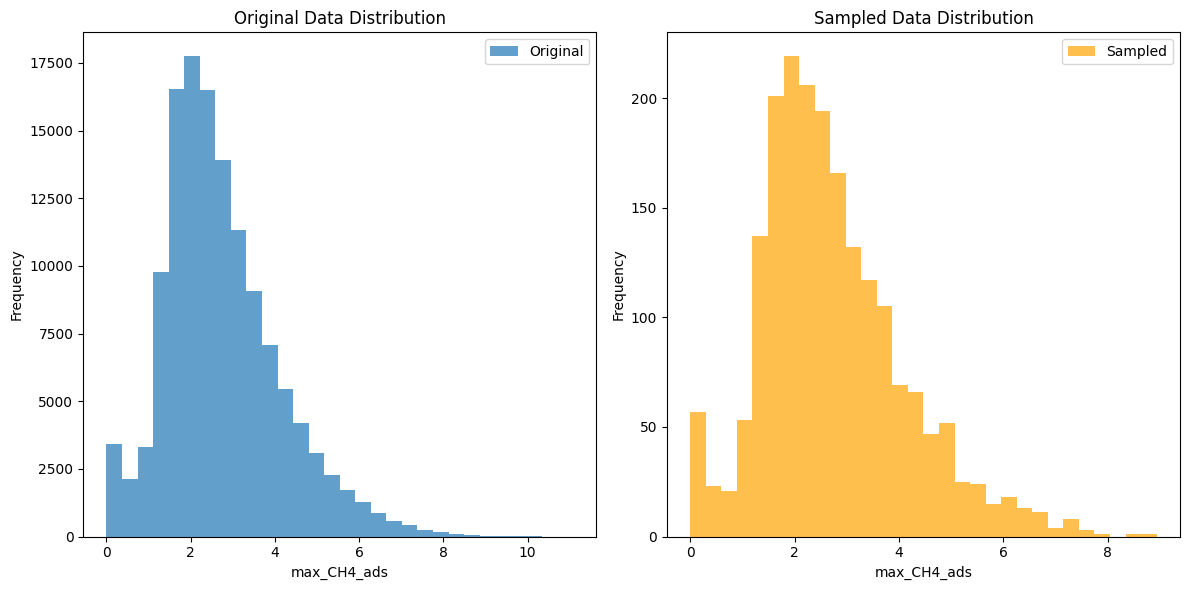

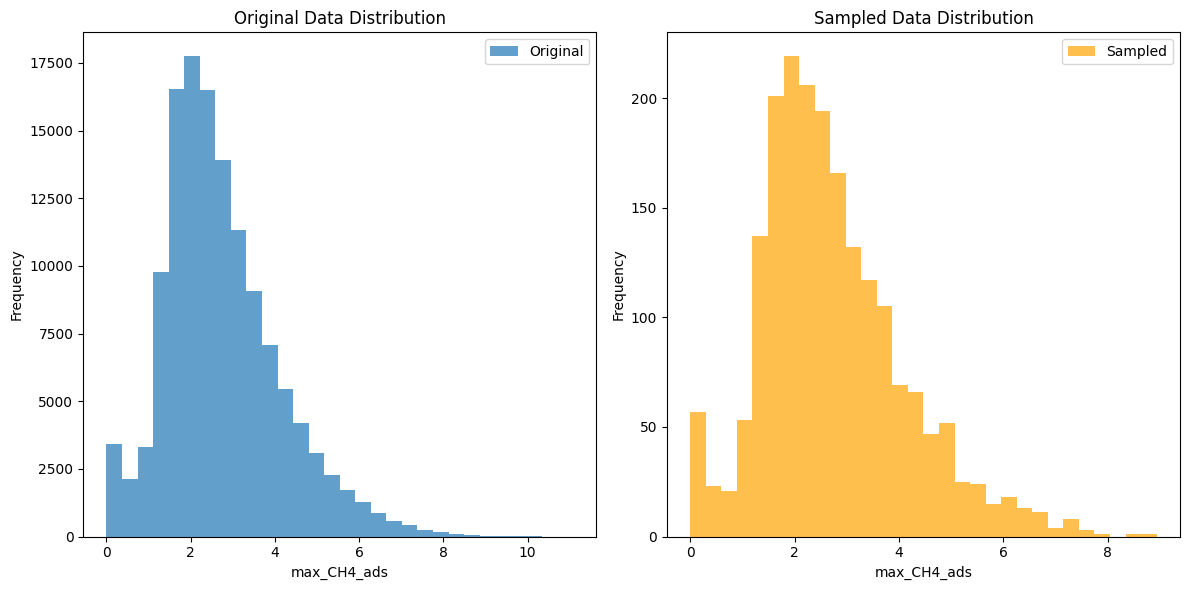

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
# Visualization of the 'max_CH4_ads' distribution in the original and sampled datasets
plt.figure(figsize=(12, 6))

# Original Data
plt.subplot(1, 2, 1)
df_filtered['max_CH4_ads'].plot(kind='hist', bins=30, alpha=0.7, label='Original')
plt.title('Original Data Distribution')
plt.xlabel('max_CH4_ads')
plt.ylabel('Frequency')
plt.legend()

# Sampled Data
plt.subplot(1, 2, 2)
sampled_df['max_CH4_ads'].plot(kind='hist', bins=30, alpha=0.7, color='orange', label='Sampled')
plt.title('Sampled Data Distribution')
plt.xlabel('max_CH4_ads')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()
